## Linear Model (Multiple Regression)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from scipy.stats import boxcox, zscore

In [2]:
# Global parameters

# Current gameweek 
gameweek = 11

# Number of gameweeks to calculate rolling averages off 
rolling_number = 3

## Collect available player data

In [3]:
# Initialize an empty list to store all individual, player gameweek data 
all_player_sep = []

# Loop through each gameweek
for i in range(1, gameweek + 1):  # Adjusting the range to start from 1 to gameweek
    # Read the CSV for the current gameweek
    x = pd.read_csv(rf'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\Players\Seperate_GW\GW_{i}.csv')
    
    # Append the current gameweek data to the list
    all_player_sep.append(x)

# Concatenate all dataframes in the list into a single dataframe
player_data = pd.concat(all_player_sep, axis=0, ignore_index=True)

# Drop unnamed column
player_data = player_data.drop(columns = ['Unnamed: 0'])

In [4]:
# Remove players who play less than 61 minutes in a game (i.e. they do not recieve their 2 points minimum for gametime)
player_data = player_data[player_data['Minutes'] > 60].copy()

In [5]:
# Filter by Goalkeepers, Defenders, Midfielders, and Forwards
final_data_mids = player_data[player_data['Position'] == 'MID'].copy()
final_data_defs = player_data[player_data['Position'] == 'DEF'].copy()
final_data_gks = player_data[player_data['Position'] == 'GK'].copy()
final_data_fwds = player_data[player_data['Position'] == 'FWD'].copy()

In [6]:
## Assess sample size of each category
print(f'GK:',final_data_gks.shape)
print(f'DEF:',final_data_defs.shape)
print(f'MID:',final_data_mids.shape)
print(f'FWD:',final_data_fwds.shape)

GK: (219, 33)
DEF: (859, 33)
MID: (952, 33)
FWD: (218, 33)


In [7]:
# Interchange between positions for different analysis 
final_data =final_data_fwds

## Correlation analysis

In [8]:
correlations = ['GW Points','Influence', 'Minutes', 'Goals', 'Assists', 'Clean Sheets',
       'Goals Conceded', 'Penalties Saved', 'Penalties Missed', 'YC', 'RC',
       'Saves', 'Total Bonus Points', 'Total BPS', 'Influence', 'Creativity',
       'Threat', 'ICT Index', 'xG', 'xA', 'xGi', 'xGc', 'Transfers In GW',
       'Transfers Out GW', 'Gameweek','Difficulty']

final_data[correlations].corr().sort_values(by = 'GW Points', ascending = False).head(40)

,GW Points,Influence,Minutes,Goals,Assists,Clean Sheets,Goals Conceded,Penalties Saved,Penalties Missed,YC,...,Threat,ICT Index,xG,xA,xGi,xGc,Transfers In GW,Transfers Out GW,Gameweek,Difficulty
GW Points,1.000000,0.933095,0.135675,0.919241,0.420485,-0.069449,0.029578,NaN,-0.120954,-0.078763,...,0.478642,0.775033,0.496746,0.071771,0.511607,-0.083974,0.090841,0.018307,-0.007501,-0.198136
Total BPS,0.957863,0.966028,0.173913,0.930949,0.325667,-0.050459,0.038932,NaN,-0.116154,-0.030822,...,0.498252,0.817566,0.489517,0.100640,0.511583,-0.055412,0.102402,-0.016180,-0.000330,-0.227128
Influence,0.933095,1.000000,0.240592,0.944585,0.253097,-0.056448,0.064113,NaN,-0.081322,0.006240,...,0.564092,0.866815,0.539611,0.069337,0.553613,-0.045040,0.128062,0.027397,-0.029597,-0.221031
Influence,0.933095,1.000000,0.240592,0.944585,0.253097,-0.056448,0.064113,NaN,-0.081322,0.006240,...,0.564092,0.866815,0.539611,0.069337,0.553613,-0.045040,0.128062,0.027397,-0.029597,-0.221031
Goals,0.919241,0.944585,0.159438,1.000000,0.091075,-0.085759,0.079861,NaN,-0.069880,0.002124,...,0.559050,0.788588,0.596635,-0.053613,0.579793,-0.049765,0.120116,0.063116,-0.037313,-0.190527
Total Bonus Points,0.883543,0.807354,0.125302,0.805555,0.196035,-0.047501,-0.045737,NaN,-0.062503,0.022093,...,0.384494,0.656398,0.359060,0.030724,0.364553,-0.068777,0.036620,0.028130,-0.032642,-0.139347
ICT Index,0.775033,0.866815,0.292008,0.788588,0.208459,-0.061528,0.033067,NaN,-0.031241,-0.041211,...,0.839051,1.000000,0.667925,0.167160,0.705439,-0.130308,0.176764,0.061410,-0.040310,-0.290755
xGi,0.511607,0.553613,0.194108,0.579793,0.093441,-0.056703,0.040715,NaN,0.097768,-0.052650,...,0.747621,0.705439,0.969052,0.147902,1.000000,-0.155152,0.198376,0.158776,-0.045360,-0.189388
xG,0.496746,0.539611,0.161104,0.596635,0.017177,-0.044475,0.024560,NaN,0.103598,-0.043741,...,0.760860,0.667925,1.000000,-0.100819,0.969052,-0.140233,0.193403,0.177317,-0.068110,-0.186017
Threat,0.478642,0.564092,0.242314,0.559050,-0.005877,-0.047893,-0.017500,NaN,0.037578,-0.064296,...,1.000000,0.839051,0.760860,-0.035160,0.747621,-0.182872,0.215542,0.128716,-0.085921,-0.261572


## Feature Selection

In [9]:
# Regression model predictors for goalkeepers
f_cols_gks = ['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today', 'Gameweek', 'Goals', 
          'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved','Penalties Missed', 'RC', 'YC']

# Regression model predictors for defenders
f_cols_defs = ['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today', 'Gameweek', 'Goals', 
          'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved','Penalties Missed', 'RC', 'YC']

# Regression model predictors for midfielders
f_cols_mids = ['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today', 'Gameweek', 'Goals', 
          'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved','Penalties Missed', 'RC', 'YC']

# Regression model predictors for forwards
f_cols_fwds = ['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today', 'Gameweek', 'Goals', 
          'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved','Penalties Missed', 'RC', 'YC']

# Regression model predictors for all positions
f_cols_all = ['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today', 'Gameweek', 'Goals', 
          'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved','Penalties Missed', 'RC', 'YC']

# Regression model target  
t_col = ['GW Points']

In [10]:
# Interchange between positions for different analysis 
features = final_data[f_cols_fwds]
target = final_data[t_col]

## Multiple Linear Regression Model

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming `features` and `target` DataFrames are already defined

# Define feature columns, excluding player-related information
features_noID = features.drop(columns=['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today', 'Gameweek'])
# Isolate player-related information (Player ID, Name, Last_Name, Team, Position, Cost_Today, Gameweek)
player_ids = features[['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today', 'Gameweek']]

# Prepare the feature matrix and target vector
X = features_noID
y = target

# Train-test split for final evaluation after cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
linear_model = LinearRegression()

# Set up k-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=0)

# Perform cross-validation (Standardizing the features within cross-validation)
r2 = cross_val_score(linear_model, X, y, scoring='r2', cv=kf)

# Print cross-validation results
print(f'MSE scores for each fold: {r2}')
print(f'Average MSE across folds: {np.mean(r2):.2f}')

# Fit the model on the entire training set for final evaluation
linear_model.fit(X_train, y_train)

# Make predictions on the test set and round to the nearest integer ( we round errrors to 0 dp, because
# players can only score exact points)
y_pred = linear_model.predict(X_test).round(0)

# Evaluate the model on the test set
r2_test = r2_score(y_test, y_pred)
print(f'Mean Squared Error on test set: {r2_test:.2f}')

# Align player information and predictions using y_test indices
predictions_df = player_ids.loc[y_test.index].copy()  # Use test indices to align player information
predictions_df['GW Points'] = y_pred # Add predictions to DataFrame

# Display the first 10 rows of the predictions DataFrame
predictions_df.head(10)

MSE scores for each fold: [1.        1.        1.        1.        0.9892426]
Average MSE across folds: 1.00
Mean Squared Error on test set: 1.00


,Player ID,Name,Last_Name,Team,Position,Cost_Today,Gameweek,GW Points
3474,232,Iliman,Ndiaye,Everton,FWD,54,6,3.0
7130,512,Michail,Antonio,West Ham,FWD,54,11,2.0
4852,268,Liam,Delap,Ipswich,FWD,57,8,2.0
6082,11,Eddie,Nketiah,Crystal Palace,FWD,59,10,2.0
557,512,Michail,Antonio,West Ham,FWD,55,1,2.0
5368,148,Danny,Welbeck,Brighton,FWD,59,9,7.0
5836,541,Matheus,Cunha,Wolves,FWD,65,9,9.0
2544,566,Jørgen,Strand Larsen,Wolves,FWD,55,4,5.0
6907,316,Darwin,Darwin,Liverpool,FWD,71,11,7.0
4901,306,Jamie,Vardy,Leicester,FWD,57,8,6.0


In [12]:
# Print the model coefficients and intercept
coefficients = linear_model.coef_.flatten().round(3)
intercept = linear_model.intercept_
features = linear_model.feature_names_in_

print(f"Coefficient (slope): {coefficients}")
print(f'Features: {features}')
print(f"Intercept (β0): {intercept}")

Coefficient (slope): [ 4.  3. -0.  1.  0.  0. -2.  0. -1.]
Features: ['Goals' 'Assists' 'Clean Sheets' 'Total Bonus Points' 'Saves'
 'Penalties Saved' 'Penalties Missed' 'RC' 'YC']
Intercept (β0): [2.]


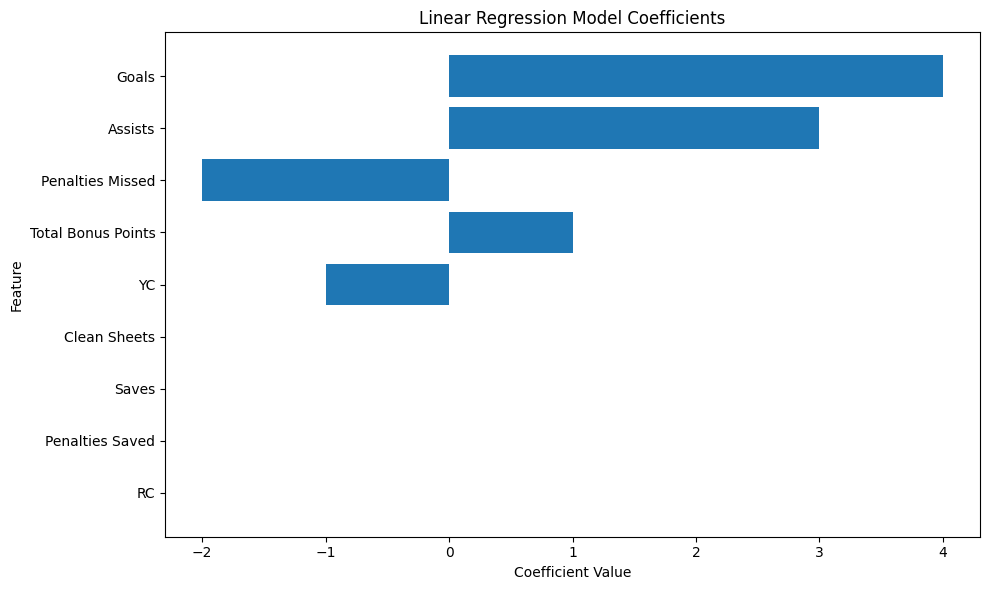

In [13]:
# Create a DataFrame for visualization
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of coefficients for better visualization
coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], align='center')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Linear Regression Model Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.tight_layout()
plt.show()

# Checking the quality of the model

## Sum of squares

- Sum of squared errors (SSr) = sum the squares of all actual values - model predicted values.
- Total sum of squares (SSt) = sum the squares of all actual values - baseline model (mean Y). 'Baseline of no relationship', where the mean of Y is used to predict all values of Y.
- Sum of squares of model (SSm) = SSt - SSr

- r2 score = SSm / SSt (The proportion of improvement due to the model. The closer to 1, the better the model.)

Our model is a perfect linear model. We know this, because FPL has defined linear rules to accumulate points. 

*Note: There are errors in the model if we group all players together. This is because there are different linear relationships between points and ways to score points for different players e.g. scoring as a midfielder gets you 5 points, whereas 4 for a forward. There are also errors for goalkeepers and defenders, because we are missing input data on 'own goals'. Some goalkeepers will have scored less than what the model predicts, due to missing information.*

## Are errors normally distributed?

- Errors are small when the model predicts values that are close to the observed points. 
- We want many red points to be as close to the blue line as possible, indicating that errors are centred about a small mean. 

Our model errors are perfectly distributed with mean 0. 

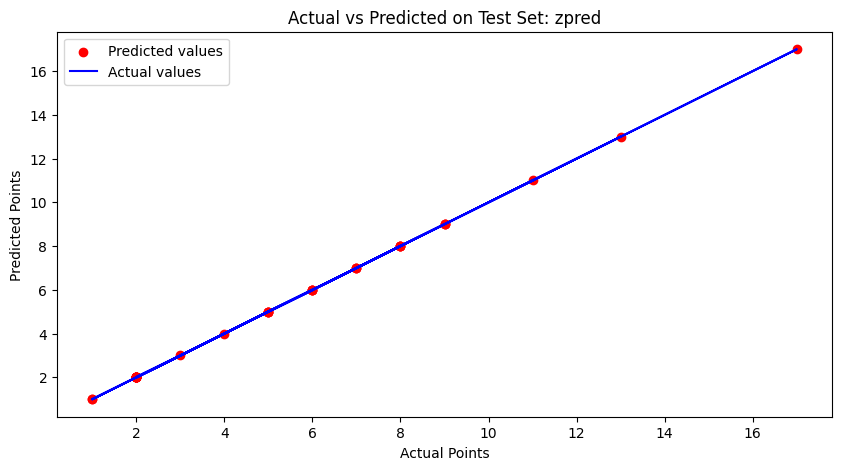

In [14]:
# Visualize predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='red', label='Predicted values')  # y_test vs predictions
plt.plot(y_test, y_test, color='blue', label='Actual values')  # Line for actual values
plt.title('Actual vs Predicted on Test Set: zpred')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.legend()
plt.show()

## Is the variance of errors heterogenious?

- When the variance of the errors (the summed distance of observed points from the predicted points) is the same as the variance of the observed value (distance away from observed mean), then we have a heterogenity of variance.
- We basically want to see residuals evenly spread either side of the prediction line for different values of x. 

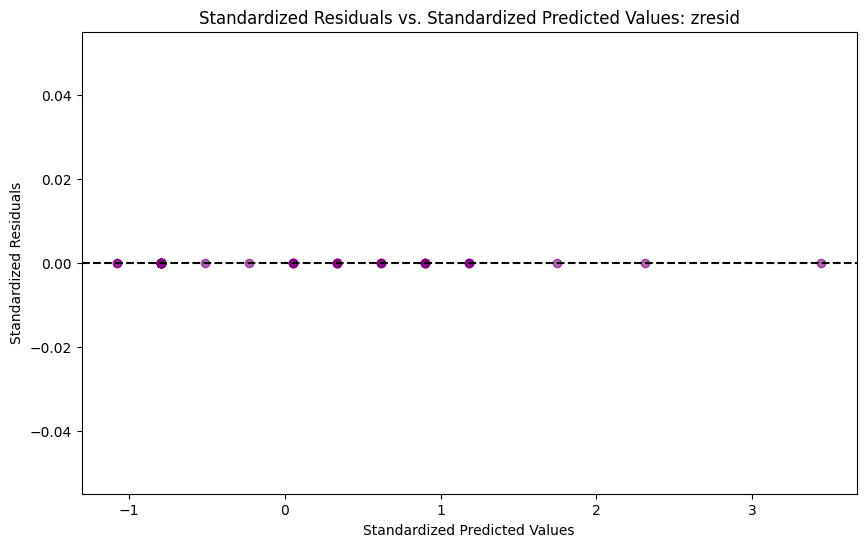

In [15]:
from sklearn.preprocessing import StandardScaler

# Calculate residuals
residuals = y_test - y_pred

# Standardize the predicted values and residuals
pred_scaler = StandardScaler()
residual_scaler = StandardScaler()

# Reshape y_pred and residuals to 2D for scaling
y_pred_std = pred_scaler.fit_transform(y_pred.reshape(-1, 1)).flatten()
residuals_std = residual_scaler.fit_transform(residuals.values.reshape(-1, 1)).flatten()

# Plot standardized residuals vs. standardized predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_std, residuals_std, color='purple', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at 0 for reference
plt.title('Standardized Residuals vs. Standardized Predicted Values: zresid')
plt.xlabel('Standardized Predicted Values')
plt.ylabel('Standardized Residuals')
plt.show()


## Model Parameters

- Parameters (b values) represent the change in outcome per unit change of the predictor, when the other variables are held constant. 

- If the parameter is 0, this reflects no relationship between predictor and outcome variable and a poor model.  

## Further Visual Analysis

We can only view 2 predictors in 3-D space, so typically feature bar grapshs are used for MLR.

c:\Users\thoma\anaconda3\envs\complete_ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


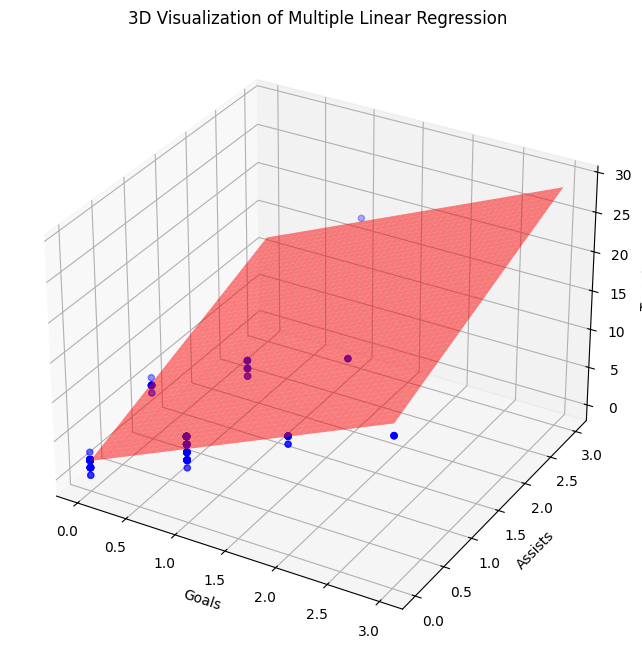

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Select two independent features and one dependent variable for visualization
X_subset = X[['Goals', 'Assists']]  # Replace with your column names
y_subset = y

# Fit the model
model = LinearRegression()
model.fit(X_subset, y_subset)

# Generate a meshgrid for the regression plane
x_range = np.linspace(X_subset['Goals'].min(), X_subset['Goals'].max(), 50)
y_range = np.linspace(X_subset['Assists'].min(), X_subset['Assists'].max(), 50)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_grid = model.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)

# Plot the 3D scatter plot of actual data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_subset['Goals'], X_subset['Assists'], y_subset, color='blue', label='Actual Data')

# Plot the regression plane
ax.plot_surface(x_grid, y_grid, z_grid, color='red', alpha=0.5, label='Regression Plane')

# Label the axes
ax.set_xlabel('Goals')
ax.set_ylabel('Assists')
ax.set_zlabel('Target')

# Show the legend and plot
plt.title('3D Visualization of 2 predictors: MLR')
plt.show()